In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 25 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 30
cfg['set_id'] = 7

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = GRU_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

GRU_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (gru): GRU(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 59.02777
count = 4, loss = 32.49439
count = 6, loss = 11.73124
count = 8, loss = 11.73477
count = 10, loss = 7.77947
count = 12, loss = 10.74035
validation loss: 5.965531349182129
epoch finished: 1
count = 2, loss = 7.53229
count = 4, loss = 9.19509
count = 6, loss = 8.64347
count = 8, loss = 8.76404
count = 10, loss = 9.51964
count = 12, loss = 7.77514
validation loss: 6.272917906443278
epoch finished: 2
count = 2, loss = 7.79030
count = 4, loss = 8.38685
count = 6, loss = 9.00330
count = 8, loss = 8.38371
count = 10, loss = 9.09835
count = 12, loss = 8.93561
validation loss: 6.312788486480713
epoch finished: 3
count = 2, loss = 8.52134
count = 4, loss = 8.25766
count = 6, loss = 8.37141
count = 8, loss = 8.08759
count = 10, loss = 8.13794
count = 12, loss = 8.65707
validation loss: 8.707082112630209
epoch finished: 4
count = 2, loss = 7.77586
count = 4, loss = 8.20230
count = 6, loss = 7.73347
count = 8, loss = 8.94758
count = 10, loss = 6.60680
count = 12, loss = 7

In [18]:
np.save('val_loss_gru_set7.npy', val_losses)
np.save('train_loss_gru_set7.npy', train_losses)

In [19]:
model = load_model(LSTM_Score, './models/s7_ba120e20b12.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [8]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 7.8503181139628095
validation MAE: 0.07497831930716832
QWK Score: 0.7090376787182419


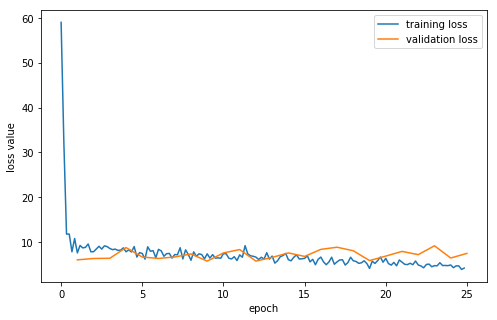

In [10]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [11]:
targets

[array([13, 13, 14, 15, 15, 14, 14, 19, 15, 18, 20, 19, 17, 15, 12, 16, 19,
        13, 14, 21, 17, 17, 19, 16, 22, 21, 10, 13, 22, 19, 17,  9, 12, 17,
        19, 22, 20, 15, 19, 14, 17, 22, 14, 16,  9, 16, 17, 19, 17, 21, 15,
        14, 21, 15, 17,  6, 14, 19, 15, 15, 17, 12, 14, 14, 17, 15, 16, 18,
        15, 15, 17, 19, 17, 17, 21, 18, 19, 14, 14, 15, 13, 21, 17, 17, 11,
        18, 19, 18, 16, 13, 13, 15, 16, 21, 19, 13, 13, 21, 21, 15, 22, 19,
        21, 17, 21, 17, 14, 14, 21, 18, 17, 13, 14, 16, 16,  8, 16, 19, 18,
        18]),
 array([11, 13, 14, 20, 17, 21, 11, 18, 12, 21, 23,  9, 23, 19, 23, 17, 16,
        16, 12, 19, 15, 12, 21, 16, 16, 16,  8, 12, 15, 16, 14, 18, 17, 15,
        15, 14, 17, 16, 13, 19,  9, 15, 15,  9, 13, 14, 21, 13, 13, 13,  4,
        13, 13, 20, 14, 19, 20, 16, 17, 17, 10, 17, 13, 16, 17, 21, 14, 15,
        20, 20, 15, 15, 14, 15, 19, 16, 18, 15, 16, 17, 16, 19, 13, 11, 11,
        20, 21, 14, 20, 19, 13,  7, 16, 15, 15, 13, 14, 14, 14, 19, 17, 15

In [12]:
preds

[array([ 9, 17, 12, 13, 17, 18, 17, 17, 14, 20, 24, 18, 19, 16, 16, 18, 20,
        11, 14, 21, 16, 17, 16, 17, 23, 23, 10,  9, 21, 23, 20, 11, 11, 13,
        19, 19, 20, 15, 20, 14, 12, 20, 15, 12, 11, 14, 16, 19, 20, 22, 19,
        10, 21, 11, 12,  7, 13, 15, 15, 12,  7, 13, 15, 14, 16,  9, 16, 18,
         9, 17, 17, 19, 17, 12, 19, 20, 17, 14, 16, 13, 13, 20, 16, 21, 10,
        19, 18, 17, 21,  9, 11, 17, 18, 19, 17, 10, 13, 26, 24, 12, 21, 19,
        21, 20, 22, 16, 21, 13, 22, 20, 16, 16, 11, 16, 15, 13, 20, 18, 14,
        18]),
 array([11, 17,  9, 22, 13, 19,  9, 21, 16, 21, 25, 10, 22, 19, 27, 18, 12,
        14, 23, 22, 19, 10, 16, 16, 14, 17, 10, 11, 13, 17, 14, 17, 19, 16,
        15, 17, 19, 11, 10, 19,  9, 15, 19, 12, 12, 15, 18, 17, 16, 16,  7,
        11, 14, 21, 17, 15, 14, 18, 14, 16, 15, 18, 12, 13, 18, 22, 12, 16,
        17, 23, 11, 14, 11, 18, 20, 16, 16, 14, 17, 17, 21, 22, 19, 11, 12,
        18, 26, 19, 15, 18, 16, 10, 16, 12, 14, 10, 12, 10, 17, 16, 22, 17

In [13]:
train_losses

[59.02776527404785,
 32.49438953399658,
 11.731235980987549,
 11.734766006469727,
 7.77947211265564,
 10.74035120010376,
 7.5322935581207275,
 9.19508981704712,
 8.643473625183105,
 8.764041423797607,
 9.519640445709229,
 7.775141477584839,
 7.790299892425537,
 8.386850833892822,
 9.003297328948975,
 8.383712530136108,
 9.098347187042236,
 8.9356050491333,
 8.52133846282959,
 8.25765585899353,
 8.37141227722168,
 8.087585210800171,
 8.137937545776367,
 8.657065391540527,
 7.7758629322052,
 8.20229721069336,
 7.733473300933838,
 8.947575569152832,
 6.606802940368652,
 7.589019536972046,
 7.396353006362915,
 6.1359241008758545,
 8.89148473739624,
 7.902795314788818,
 8.027564525604248,
 6.464365482330322,
 8.325835704803467,
 7.9845051765441895,
 6.776888132095337,
 7.354723930358887,
 7.4137818813323975,
 6.359195232391357,
 7.167545557022095,
 7.112033128738403,
 8.682569026947021,
 6.173433065414429,
 8.204911708831787,
 7.190329313278198,
 5.877859354019165,
 7.748938322067261,
 6.77

In [14]:
val_losses

[5.965531349182129,
 6.272917906443278,
 6.312788486480713,
 8.707082112630209,
 6.593011220296224,
 6.279424508412679,
 6.606142044067383,
 7.285980701446533,
 5.679375966389974,
 7.509109656016032,
 8.261078516642252,
 5.68380069732666,
 6.5116400718688965,
 7.514255046844482,
 6.733325322469075,
 8.304178555806478,
 8.786745389302572,
 7.9961957931518555,
 5.804825146993001,
 6.808566729227702,
 7.851907571156819,
 7.127610365549724,
 9.109251340230307,
 6.377525806427002,
 7.407655715942383]